# Crash Predictive ML Model

We will create a tree based model to predict the daily number of crashes at a known intersection using the following:
- weather (temp, snow, rain, precip)
- day of week (Mon, Tues...)
- intersection characteristics
    - speed limit
    - volume of traffic
    - region
    - lanes/ways/turns/split/exit etc.
- violations (may want a violations independent model)
- red light cam present

In [606]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from modules.myfuncs import *


import warnings
warnings.filterwarnings('ignore')


# Decision Tree
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support


In [607]:
conn = create_connection('database/rlc2.db')  # function from myfuncs file
c = conn.cursor()

sqlite3 version: 2.6.0
connected to database/rlc2.db



We will try to get data that is daily for all of the above info.  

In [608]:
print(sql_fetch_tables(c, conn))



def table_info(c, conn):
    '''
    prints out all of the columns of every table in db
    c : cursor object
    conn : database connection object
    '''
    tables = c.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
    for table_name in tables:
        table_name = table_name[0]
        table = pd.read_sql_query("SELECT * from {} LIMIT 0".format(table_name), conn)
        print(table_name)
        for col in table.columns:
            print('\t' + col)
        print()

table_info(c, conn)


[('cam_locations',), ('cam_startend',), ('daily_violations',), ('all_crashes',), ('hourly_congestion',), ('hourly_weather',), ('region_data',), ('intersection_cams',), ('signal_crashes',), ('int_startend',), ('intersection_chars',), ('all_hours',)]
cam_locations
	camera_id
	intersection
	address
	violation_date
	violations
	latitude
	longitude
	month
	day
	weekday
	year

cam_startend
	camera_id
	start
	end

daily_violations
	intersection
	camera_id
	address
	violation_date
	violations
	latitude
	longitude
	month
	day
	weekday
	year

all_crashes
	crash_record_id
	rd_no
	crash_date
	posted_speed_limit
	traffic_control_device
	device_condition
	weather_condition
	lighting_condition
	first_crash_type
	trafficway_type
	alignment
	roadway_surface_cond
	road_defect
	report_type
	crash_type
	damage
	prim_contributory_cause
	sec_contributory_cause
	street_no
	street_direction
	street_name
	beat_of_occurrence
	num_units
	most_severe_injury
	injuries_total
	injuries_fatal
	injuries_incapacitating

## Query our data
I would like to get hourly intersection data with the following columns:


signal_crashes
	-crash_date
	-posted_speed_limit
	-device_condition
	-weather_condition
	-lighting_condition
	-first_crash_type
	-trafficway_type
	-alignment
	-roadway_surface_cond
	-road_defect
	-report_type
	-crash_type
	-damage
	-prim_contributory_cause
	-sec_contributory_cause
	-street_no
	-street_direction
	-street_name
	-most_severe_injury
	-injuries_total
	-injuries_fatal
	-injuries_incapacitating
	-injuries_non_incapacitating
	-injuries_reported_not_evident
	-injuries_no_indication
	-injuries_unknown
	-latitude
	-longitude
	-lane_cnt
	-work_zone_i
	-work_zone_type
	-workers_present_i
	-intersection
	-year
	-month
	-day
	-hour
	-region_id
	-time
	-weekday

hourly_weather
	-temp
	-rain_1h
	-rain_3h
	-snow_1h
	-snow_3h
	-time
	-year
	-month
	-day
	-hour
	-weekday

hourly_congestion
	-year
	-month
	-day
	-hour
	-region_id
	-bus_count
	-num_reads
	-speed
	-weekday
    
Tables will be queried to JOIN on year, month, day, hour

WHAT I REALLY NEED HERE
A single dataset with the following:
- daily intersection chars (all the stuff I entered)
- daily intersection crashes (injuries, deaths, number etc)
- daily wx (temp, precip mainly)
- daily congestion (might not need this)
- daily violations (already in the format)

In [609]:
# Approximately how many entries should I expect to be looking at after filtering my data
# 3 years, 4 months x 153 intersections
print((365.25*3 + 30*4) *153)


186009.75


## Query my db to get a DataFrame with crashes and intersection
We will be using the number of crashes and injuries to do some t-tests

In [451]:
# THis is for the times the cams were off

all_df = pd.read_sql_query('''WITH v AS(SELECT d.intersection,
                                                dv.violation_date,
                                                dv.violations,
                                                d.year,
                                                d.month,
                                                d.day,
                                                dv.weekday
                                               
                                        FROM all_hours as d

                                        LEFT JOIN daily_violations as dv
                                            ON d.year = dv.year
                                            AND d.month = dv.month
                                            AND d.day = dv.day
                                            AND d.intersection = dv.intersection   
                                        ), 
                                        
                                    se AS(SELECT *
                                        FROM int_startend as se
                                        ),
                                        
                                    cr AS(SELECT *
                                        FROM signal_crashes
                                        ),
                                        
                                    ic AS(SELECT *
                                        FROM intersection_chars
                                        ),
                                        
                                    rg AS(SELECT *
                                        FROM intersection_cams)
                                        
                                    SELECT  v.intersection,
                                            v.violation_date,
                                            v.violations,
                                            v.year,
                                            v.month,
                                            v.day,
                                            v.weekday
                                           
                                    FROM v
                                   
                                    ''', conn)

#crash_df = pd.read_sql_query('''SELECT * FROM signal_crashes''', conn)
                                        
#violations_df = pd.read_sql_query('''SELECT * FROM daily_violations''', conn)  
#days_df = pd.read_sql_query('''SELECT * FROM all_hours''', conn)  

In [1188]:
# THis is for the times the cams were off

all_df = pd.read_sql_query('''WITH v AS(SELECT d.year,
                                                d.month,
                                                d.day,
                                                d.intersection,
                                                dv.violations,
                                                dv.violation_date,
                                                dv.weekday
                                               
                                        FROM all_hours as d

                                        LEFT JOIN daily_violations as dv
                                            ON d.year = dv.year
                                            AND d.month = dv.month
                                            AND d.day = dv.day
                                            AND d.intersection = dv.intersection
                                                
                                        ), 
                                        
                                    se AS(SELECT *
                                         FROM int_startend as se
                                        ),
                                        
                                    cr AS(SELECT *
                                         FROM signal_crashes
                                        ),
                                        
                                    ic AS(SELECT *
                                        FROM intersection_chars
                                        ),
                                        
                                    rg AS(SELECT *
                                        FROM intersection_cams),
                                        
                                    wx AS(SELECT MAX(temp) AS temp,
                                                (SUM(snow_1h) + SUM(rain_1h)) AS precip,
                                                SUM(snow_1h) AS snow_1h,
                                                SUM(rain_1h) AS rain_1h,
                                                year,
                                                month,
                                                day
                                        FROM hourly_weather
                                        GROUP BY year, month, day
                                        )
                                        
                                    SELECT  v.intersection,
                                            v.violation_date,
                                            v.violations,
                                            v.year,
                                            v.month,
                                            v.day,
                                            CAST(v.weekday AS TEXT) AS weekday,
                                    
                                            COUNT(DISTINCT cr.crash_record_id) as n_crash,

                                            cr.prim_contributory_cause,
                                            cr.sec_contributory_cause,
                                            SUM(cr.injuries_total) AS injuries,
                                            SUM(cr.injuries_fatal) AS injuries_fatal,
                                            SUM(cr.injuries_incapacitating) AS injuries_incapacitating,
                                                                                        
                                            ic.protected_turn,
                                            ic.total_lanes,
                                            ic.medians,
                                            ic.exit,
                                            ic.split,
                                            ic.way,
                                            ic.underpass,
                                            ic.no_left,
                                            ic.angled,
                                            ic.triangle,
                                            ic.one_way,
                                            ic.turn_lanes,
                                            ic.lat,
                                            ic.long,
                                            ic.rlc,
                                            ic.daily_traffic,
                                            ic.speed,

                                            se.start,
                                            se.end,
                                            
                                            rg.region_id,
                                            
                                            wx.temp,
                                            wx.precip,
                                            wx.snow_1h,
                                            wx.rain_1h
                                            
                                            
                                    FROM v
                                    LEFT JOIN wx
                                        ON wx.year = v.year
                                        AND wx.month = v.month
                                        AND wx.day = v.day
                                    LEFT JOIN se
                                        ON se.intersection = v.intersection
                                    LEFT JOIN ic
                                        ON ic.intersection = v.intersection
                                    LEFT JOIN rg
                                        ON rg.intersection = v.intersection
                                    LEFT JOIN cr
                                        ON cr.intersection = v.intersection
                                        AND cr.year = v.year
                                        AND cr.month = v.month
                                        AND cr.day = v.day
                                       
                                    WHERE v.violation_date >= \'2017-09-01\'

                                    GROUP BY v.year, v.month, v.day, v.intersection
                                    
                                    ORDER BY v.year, v.month, v.day, v.intersection
                                    ''', conn)

#crash_df = pd.read_sql_query('''SELECT * FROM signal_crashes''', conn)
                                        
#violations_df = pd.read_sql_query('''SELECT * FROM daily_violations''', conn)  
#days_df = pd.read_sql_query('''SELECT * FROM all_hours''', conn)  

#COUNT(DISTINCT dv.camera_id) as n_cams,



# BELOW IS A GUIDE FOR LATER.  I just don't need crash data right now
# GROUP_CONCAT(cr.weather_condition) as weather_condition,
#                                             GROUP_CONCAT(cr.lighting_condition) as lighting_condition,
#                                             GROUP_CONCAT(cr.first_crash_type) as first_crash_type,
#                                             GROUP_CONCAT(cr.alignment) as alignment,
#                                             GROUP_CONCAT(cr.crash_type) as crash_type,
#                                             GROUP_CONCAT(cr.damage) as damage,
#                                             cr.prim_contributory_cause,
#                                             cr.sec_contributory_cause,
#                                             cr.most_severe_injury,
#                                             cr.injuries_total,
#                                             cr.injuries_fatal,
#                                             cr.injuries_incapacitating,
#                                             cr.work_zone_i,
#                                             cr.workers_present_i,
#                                             cr.intersection,
#                                             cr.region_id,

# all_df['weather_condition'] = all_df['weather_condition'].fillna('NONE')
# all_df['lighting_condition'] = all_df['lighting_condition'].fillna('NONE')

# all_df.weather_condition.unique()

# 'OTHER,CLEAR,OTHER,CLEAR'.split(',')
# all_df['weather_condition'] = all_df['weather_condition'].apply(lambda x: x.split(','))  # max of three per day at single intersection
# all_df['lighting_condition'] = all_df['lighting_condition'].apply(lambda x: x.split(','))  # max of three per day at single intersection

In [1309]:
# weekly query

# THis is for the times the cams were off

all_df = pd.read_sql_query('''WITH v AS(SELECT d.year,
                                                d.month,
                                                d.day,
                                                d.intersection,
                                                dv.violations,
                                                dv.violation_date,
                                                dv.weekday
                                               
                                        FROM all_hours as d

                                        LEFT JOIN daily_violations as dv
                                            ON d.year = dv.year
                                            AND d.month = dv.month
                                            AND d.day = dv.day
                                            AND d.intersection = dv.intersection
                                                
                                        ), 
                                        
                                    se AS(SELECT *
                                         FROM int_startend as se
                                        ),
                                        
                                    cr AS(SELECT *
                                         FROM signal_crashes
                                        ),
                                        
                                    ic AS(SELECT *
                                        FROM intersection_chars
                                        ),
                                        
                                    rg AS(SELECT *
                                        FROM intersection_cams),
                                        
                                    wx AS(SELECT MAX(temp) AS temp,
                                                (SUM(snow_1h) + SUM(rain_1h)) AS precip,
                                                SUM(snow_1h) AS snow_1h,
                                                SUM(rain_1h) AS rain_1h,
                                                year,
                                                month,
                                                day
                                        FROM hourly_weather
                                        GROUP BY year, month, day
                                        )
                                        
                                    SELECT  strftime('%W',v.violation_date) AS week,
                                            v.intersection,
                                            v.violation_date,
                                            v.violations,
                                            v.year,
                                            v.month,
                                            v.day,
                                        
                                            CAST(v.weekday AS TEXT) AS weekday,
                                    
                                            COUNT(DISTINCT cr.crash_record_id) as n_crash,

                                            cr.prim_contributory_cause,
                                            cr.sec_contributory_cause,
                                            SUM(cr.injuries_total) AS injuries,
                                            SUM(cr.injuries_fatal) AS injuries_fatal,
                                            SUM(cr.injuries_incapacitating) AS injuries_incapacitating,
                                                                                        
                                            ic.protected_turn,
                                            ic.total_lanes,
                                            ic.medians,
                                            ic.exit,
                                            ic.split,
                                            ic.way,
                                            ic.underpass,
                                            ic.no_left,
                                            ic.angled,
                                            ic.triangle,
                                            ic.one_way,
                                            ic.turn_lanes,
                                            ic.lat,
                                            ic.long,
                                            ic.rlc,
                                            ic.daily_traffic,
                                            ic.speed,

                                            se.start,
                                            se.end,
                                            
                                            rg.region_id,
                                            
                                            wx.temp,
                                            wx.precip,
                                            wx.snow_1h,
                                            wx.rain_1h
                                            
                                            
                                    FROM v
                                    LEFT JOIN wx
                                        ON wx.year = v.year
                                        AND wx.month = v.month
                                        AND wx.day = v.day
                                    LEFT JOIN se
                                        ON se.intersection = v.intersection
                                    LEFT JOIN ic
                                        ON ic.intersection = v.intersection
                                    LEFT JOIN rg
                                        ON rg.intersection = v.intersection
                                    LEFT JOIN cr
                                        ON cr.intersection = v.intersection
                                        AND cr.year = v.year
                                        AND cr.month = v.month
                                        AND cr.day = v.day
                                       
                                    WHERE v.violation_date >= \'2017-09-01\'

                                    
                                    GROUP BY v.year, week, v.intersection
                                    ORDER BY v.year, week, v.intersection;
                                    ''', conn)



In [1308]:
print(all_df.info())
all_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25648 entries, 0 to 25647
Data columns (total 38 columns):
week                       25648 non-null object
intersection               25648 non-null object
violation_date             25648 non-null object
violations                 25648 non-null int64
year                       25648 non-null int64
month                      25648 non-null int64
day                        25648 non-null int64
weekday                    25648 non-null object
n_crash                    25648 non-null int64
prim_contributory_cause    763 non-null object
sec_contributory_cause     763 non-null object
injuries                   25648 non-null int64
injuries_fatal             4803 non-null float64
injuries_incapacitating    4803 non-null float64
protected_turn             25648 non-null int64
total_lanes                25648 non-null int64
medians                    25648 non-null int64
exit                       25648 non-null int64
split                  

,week,intersection,violation_date,violations,year,month,day,weekday,n_crash,prim_contributory_cause,sec_contributory_cause,injuries,injuries_fatal,injuries_incapacitating,protected_turn,total_lanes,medians,exit,split,way,underpass,no_left,angled,triangle,one_way,turn_lanes,lat,long,rlc,daily_traffic,speed,start,end,region_id,temp,precip,snow_1h,rain_1h
0,35,115TH AND HALSTED,2017-09-01 00:00:00,11,2017,9,1,4,0,None,None,0,NaN,NaN,4,6,2,0,0,4,0,0,0,0,0,4,41.685089,-87.642094,1,42500,35,2016-01-02 00:00:00,2017-10-26 00:00:00,26,294.15,0.0,0.0,0.0
1,35,119TH AND HALSTED,2017-09-01 00:00:00,7,2017,9,1,4,0,None,None,0,NaN,NaN,4,6,2,0,0,4,0,0,0,0,0,4,41.677774,-87.641930,1,41800,35,2016-01-02 00:00:00,2021-01-19 00:00:00,26,294.15,0.0,0.0,0.0
2,35,31ST ST AND MARTIN LUTHER KING DRIVE,2017-09-01 00:00:00,10,2017,9,1,4,1,FAILING TO REDUCE SPEED TO AVOID CRASH,NOT APPLICABLE,0,0.0,0.0,2,10,2,0,1,4,0,2,0,0,0,0,41.838441,-87.617338,1,36500,35,2016-01-02 00:00:00,2021-01-19 00:00:00,16,294.15,0.0,0.0,0.0
3,35,35TH AND WESTERN,2017-09-01 00:00:00,5,2017,9,1,4,0,None,None,0,NaN,NaN,2,8,2,0,1,4,0,0,0,0,0,2,41.830281,-87.684775,1,42400,35,2016-01-02 00:00:00,2021-01-19 00:00:00,15,294.15,0.0,0.0,0.0
4,35,4700 WESTERN,2017-09-01 00:00:00,5,2017,9,1,4,0,None,None,0,NaN,NaN,3,12,2,0,1,4,0,0,0,0,0,2,41.808442,-87.684183,1,58800,40,2016-01-02 00:00:00,2021-01-19 00:00:00,18,294.15,0.0,0.0,0.0


In [1270]:

y = all_df['n_crash'].fillna(0).astype(bool)

drop_cols = ['violation_date', 'day', 'prim_contributory_cause', 'sec_contributory_cause', 'injuries', 'injuries_fatal', 
             'injuries_incapacitating', 'start', 'end', 'n_crash', 'lat', 'long', 'rlc', 'n_crash']
categoricals = ['region_id', 'weekday']

X = all_df.drop(columns=drop_cols) 


In [1271]:
#X.week = X.week.astype(int)
# Change crash to a boolean value
y = y.astype(int)

In [1272]:
all_df['n_crash'].value_counts()
#165550 / 5245
#5245 / 137
#137/10

X = pd.get_dummies(X)
X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170942 entries, 0 to 170941
Columns: 207 entries, violations to region_id_9
dtypes: float64(4), int64(17), uint8(186)
memory usage: 57.7 MB


### WOuld like to do some feature elimination
Doing this for the Logistic Regression model

In [1273]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(fit_intercept=False, solver='liblinear')


rfe = RFE(logreg)
rfe = rfe.fit(X, y)  # convert to int before using in logistic so I can do binary

In [1274]:
auto_drop = []

for i in range(len(X.columns)):
    if rfe.support_[i]:
        print('Use: ', rfe.ranking_[i], X.columns[i])
    else:
        print('Elim:', rfe.ranking_[i], X.columns[i])
        auto_drop.append(X.columns[i])

Use:  1 violations
Use:  1 year
Use:  1 month
Use:  1 protected_turn
Use:  1 total_lanes
Use:  1 medians
Use:  1 exit
Use:  1 split
Use:  1 way
Elim: 9 underpass
Use:  1 no_left
Use:  1 angled
Use:  1 triangle
Use:  1 one_way
Use:  1 turn_lanes
Use:  1 daily_traffic
Use:  1 speed
Use:  1 temp
Use:  1 precip
Use:  1 snow_1h
Use:  1 rain_1h
Elim: 99 intersection_115TH AND HALSTED
Elim: 50 intersection_119TH AND HALSTED
Elim: 35 intersection_31ST ST AND MARTIN LUTHER KING DRIVE
Elim: 2 intersection_35TH AND WESTERN
Use:  1 intersection_4700 WESTERN
Elim: 8 intersection_55TH AND KEDZIE
Elim: 84 intersection_55TH AND WESTERN
Elim: 67 intersection_55TH and PULASKI
Use:  1 intersection_63RD AND STATE
Elim: 85 intersection_71ST AND ASHLAND
Use:  1 intersection_75TH AND STATE
Elim: 41 intersection_79TH AND HALSTED
Elim: 26 intersection_79TH AND KEDZIE
Use:  1 intersection_87TH AND VINCENNES
Use:  1 intersection_99TH AND HALSTED
Use:  1 intersection_ADDISON AND HARLEM
Elim: 57 intersection_ARCHE

In [1275]:
# accept the RFE results automatically
X = X.drop(columns=auto_drop) 


### Train test split

In [1276]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [1277]:
import pandas as pd
import numpy as np
import itertools

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE, ADASYN

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

AUC: 0.5226755627732966


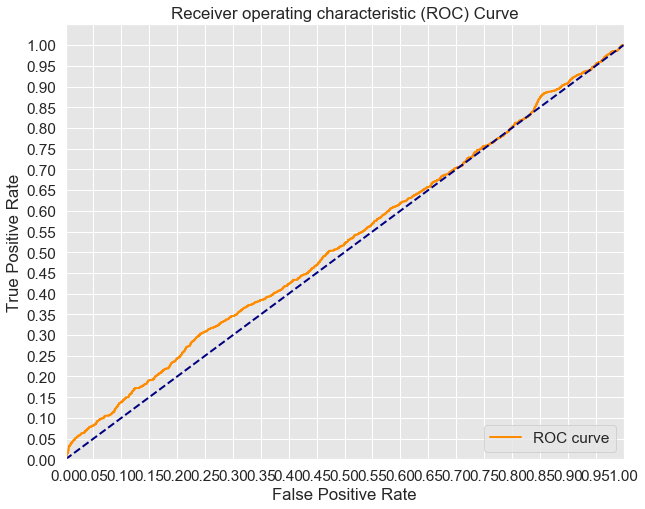

In [1278]:
# Try logistic regression?
# baseline model
X2 = X.copy()
y2 = y.copy()

y2 = y2.apply(lambda x: 1 if x > 0 else 0)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.20, random_state=42)



# Initial Model
logreg = LogisticRegression(fit_intercept=False, solver='liblinear')

# Probability scores for test set
y_score = logreg.fit(X2_train, y2_train).decision_function(X_test)
# False positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y2_test, y_score)

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Print AUC
print('AUC: {}'.format(auc(fpr, tpr)))

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

LogisticRegression(C=1e-06, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 1e-06: 0.5226759670731713
-------------------------------------------------------
LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.001: 0.5226755897266215
-------------------------------------------------------
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
      

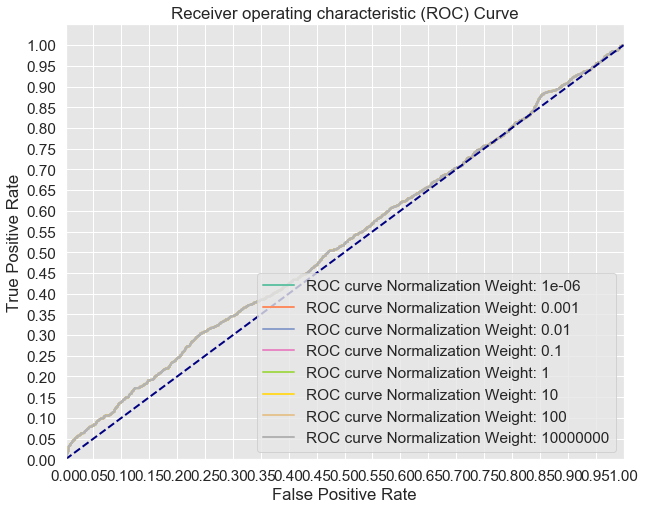

In [1279]:
# Now let's compare a few different regularization performances on the dataset:
C_param_range = [0.000001, 0.001, 0.01, 0.1, 1, 10, 100, 10000000]
names = [0.000001, 0.001, 0.01, 0.1, 1, 10, 100, 10000000]
colors = sns.color_palette('Set2')

plt.figure(figsize=(10, 8))

for n, c in enumerate(C_param_range):
    # Fit a model
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='liblinear')
    model_log = logreg.fit(X2_train, y2_train)
    print(model_log) # Preview model params

    # Predict
    y_hat_test = logreg.predict(X2_test)

    y_score = logreg.fit(X2_train, y2_train).decision_function(X2_test)

    fpr, tpr, thresholds = roc_curve(y2_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------')
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Normalization Weight: {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

LogisticRegression(C=0.005, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.005: 0.6244525577546415
-------------------------------------------------------
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.1: 0.6042481027689313
-------------------------------------------------------
LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
           

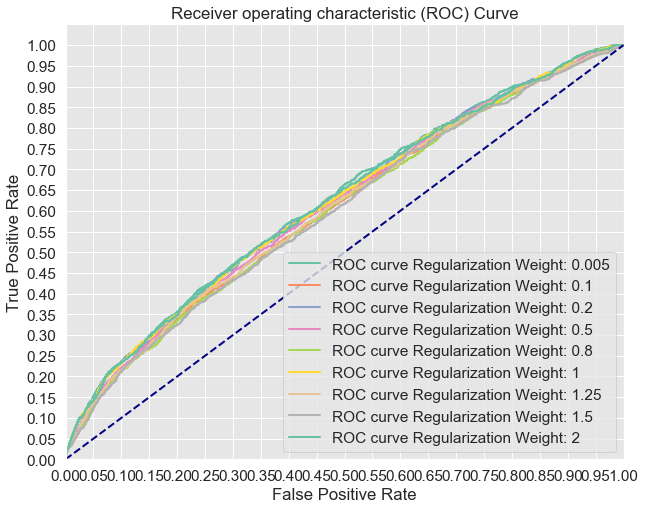

In [1280]:
# SMOTE OVERSAMPLING

# Now let's compare a few different regularization performances on the dataset
C_param_range = [0.005, 0.1, 0.2, 0.5, 0.8, 1, 1.25, 1.5, 2]
names = [0.005, 0.1, 0.2, 0.5, 0.8, 1, 1.25, 1.5, 2]
colors = sns.color_palette('Set2', n_colors=len(names))

plt.figure(figsize=(10, 8))

for n, c in enumerate(C_param_range):
    # Fit a model
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='liblinear')
    model_log = logreg.fit(X_train_resampled, y_train_resampled)
    print(model_log) # Preview model params

    # Predict
    y_hat_test = logreg.predict(X2_test)

    y_score = logreg.fit(X_train_resampled, y_train_resampled).decision_function(X2_test)

    fpr, tpr, thresholds = roc_curve(y2_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------')
    
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Regularization Weight: {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [1281]:
print(len(y)/y.sum())
y.describe()

31.702893175074184


count    170942.000000
mean          0.031543
std           0.174780
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: n_crash, dtype: float64

AUC: 0.5679000885524539
-------------------------------------------------------
LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


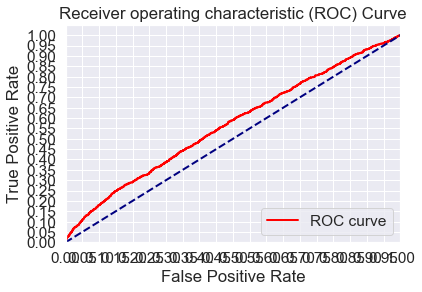

In [1300]:
# single SMOTE
logreg = LogisticRegression(fit_intercept=False, C=0.2, solver='liblinear')
model_log = logreg.fit(X_train_resampled, y_train_resampled)

# Predict
y_hat_test = logreg.predict(X2_test)

y_score = logreg.fit(X_train_resampled, y_train_resampled).decision_function(X2_test)

fpr, tpr, thresholds = roc_curve(y2_test, y_score)

print('AUC:', auc(fpr, tpr))
print('-------------------------------------------------------')

lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='ROC curve')

print(logreg)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [1301]:
#SMOTE
# Previous original class distribution
print(y2_train.value_counts()) 

# Fit SMOTE to training data
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X2_train, y2_train) 

# Preview synthetic sample class distribution
print('\n')
print(pd.Series(y_train_resampled).value_counts()) 

# Note, if you get an Attribute Error: 'SMOTE' object has no attribute
# '_validate_data', then downgrade your version of imblearn to 0.6.2
# or upgrade your version of sklearn to 0.23

0    132483
1      4270
Name: n_crash, dtype: int64


1    132483
0    132483
dtype: int64


In [1302]:
y_test.mean()

0.032817572903565476

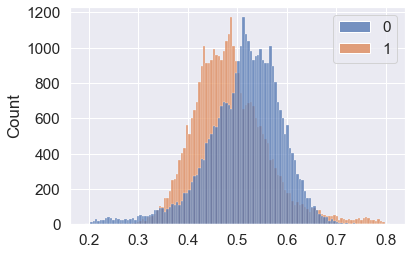

0.6408264485003847


0.6284769955248765

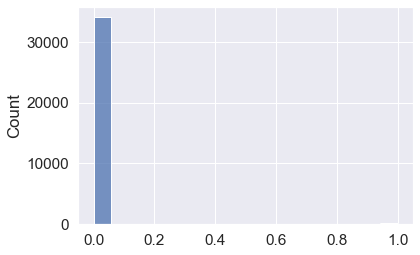

In [1303]:
y_testprob = logreg.predict_proba(X2_test)
y_testbool = logreg.predict(X2_test)


sns.histplot(y_testprob)
plt.show()

print(np.quantile(y_testprob, 0.968))

decisions = (logreg.predict_proba(X2_test)[:,0] >= 0.682).astype(int)
sns.histplot(decisions, kde=False)


logreg.score(X2_test, y2_test)

In [1304]:
cm = confusion_matrix( decisions, y2_test.astype(int))
#y2_test.unique()
cm

array([[32927,  1120],
       [  140,     2]])

In [1305]:
print(decisions.sum()/len(X2_test))  # only 3.2% are positive
print(y_testbool.sum()/len(X2_test)) # our model predicts at almost 40% rate without correcting cutoff
print(y_testbool.sum())

0.004153382666939659
0.3687150837988827
12606


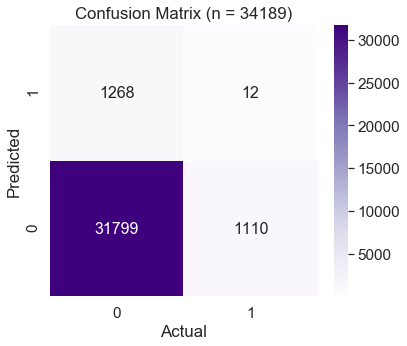

In [1298]:
fig, ax = plt.subplots(figsize = (6,5))
sn.set_context('poster')
sn.set(font_scale=1.4)#for label size
sn.heatmap(cm, cmap="Purples", annot=True, fmt='g', annot_kws={"size": 16})# font size

plt.title("Confusion Matrix (n = {})".format(len(y_test)))
plt.xlabel('Actual')
plt.ylabel('Predicted')
# Hide major tick labels


# Customize minor tick labels
ax.set_ylim([0,2])
ax.set_xlim([0,2])


#plt.annotate("No Crash: 0\n   Crash: 1", [1.1,0.1], fontsize=10)

plt.show()
# worked with other environment


# accuracy 
#precision_recall_fscore_support(y_test, xg_final.predict(X_test), average='weighted')

In [1299]:
# Machine learning improvement
n = cm[0].sum() + cm[1].sum()  # all test 

p0 = y_test.sum() / len(y_test)  # what is the guess rate I would use if I didn't know anything else
p1 = 1 - p0

guessing = p0**2 + p1**2

print('Probability with guessing: {:.3f}'.format(guessing))

ml = (cm[1][1] + cm[0][0]) / n
print('Probability with machine learning: {:.3f}'.format(ml))

increase = (ml - guessing) / guessing
print('\nPercent increase: {:.2%}'.format(increase))

Probability with guessing: 0.937
Probability with machine learning: 0.930

Percent increase: -0.65%
